In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['apple', 'apricot', 'avocado', 'banana', 'beef','beetroot', 'bell pepper', 'blackberry', 'blueberry', 'broccoli','cabbage', 'carrot', 'cauliflower', 'cherry', 'chilli pepper', 'corn', 'cranberry', 'cucumber', 'egg', 'eggplant', 'garlic', 'ginger', 'grapefruit', 'grapes', 'guava', 'jalapeno', 'kiwi', 'lemon', 'lettuce', 'lime', 'mango', 'muskmelon', 'onion', 'orange', 'papaya', 'paprika', 'passion fruit', 'peanut', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'pumpkin', 'raddish', 'raspberry', 'spinach', 'strawberry', 'sweetpotato', 'tomato', 'turnip', 'watermelon', 'white mushroom', 'zucchini' ]

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/pollo809/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:09<00:00, 35.3MB/s] 


In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 54]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:
# Setup directory paths to train and test images
train_dir = 'dataset/train'
test_dir = 'dataset/test'

In [7]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [10]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4745 | train_acc: 0.8761 | test_loss: 0.2543 | test_acc: 0.9297
Epoch: 2 | train_loss: 0.2369 | train_acc: 0.9329 | test_loss: 0.1868 | test_acc: 0.9483
Epoch: 3 | train_loss: 0.1891 | train_acc: 0.9463 | test_loss: 0.1557 | test_acc: 0.9584
Epoch: 4 | train_loss: 0.1612 | train_acc: 0.9540 | test_loss: 0.1483 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.1411 | train_acc: 0.9598 | test_loss: 0.1349 | test_acc: 0.9627
Epoch: 6 | train_loss: 0.1284 | train_acc: 0.9635 | test_loss: 0.1196 | test_acc: 0.9670
Epoch: 7 | train_loss: 0.1173 | train_acc: 0.9667 | test_loss: 0.1117 | test_acc: 0.9713
Epoch: 8 | train_loss: 0.1090 | train_acc: 0.9693 | test_loss: 0.1066 | test_acc: 0.9721
Epoch: 9 | train_loss: 0.1023 | train_acc: 0.9716 | test_loss: 0.1087 | test_acc: 0.9735
Epoch: 10 | train_loss: 0.0950 | train_acc: 0.9729 | test_loss: 0.0984 | test_acc: 0.9752


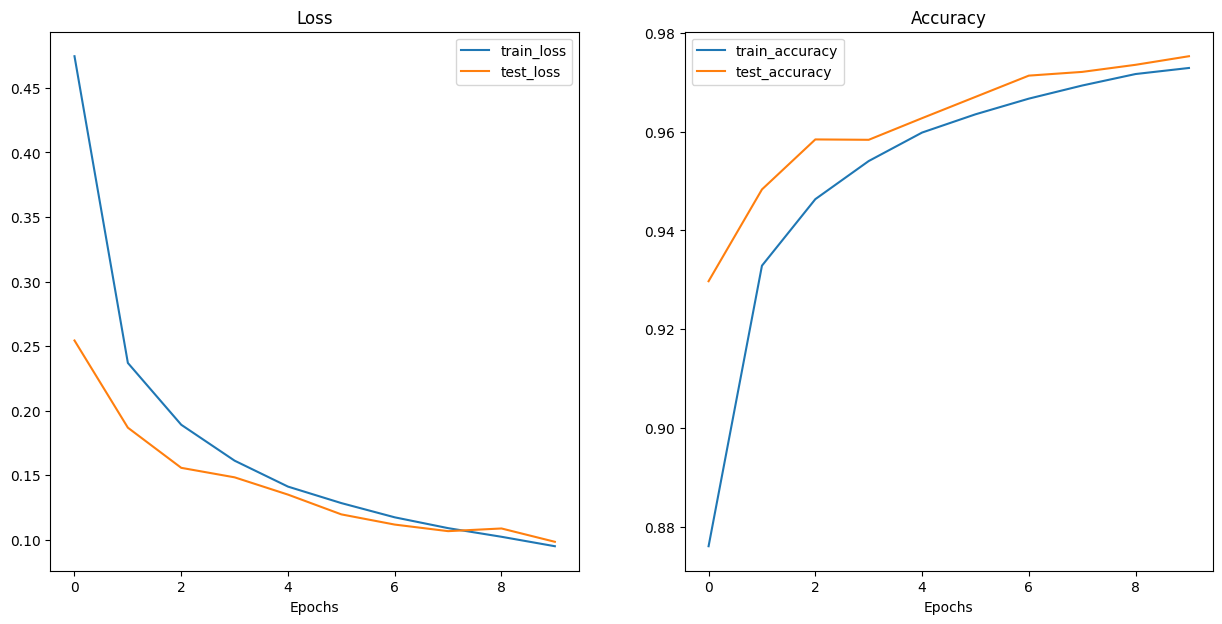

In [11]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

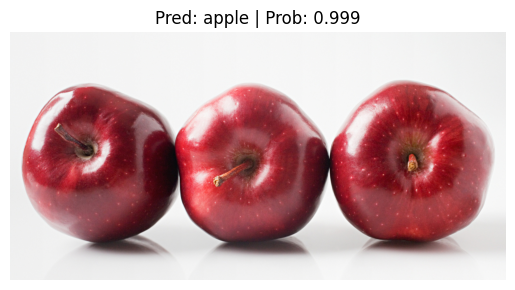

In [13]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "dataset/validation/apple/image_3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

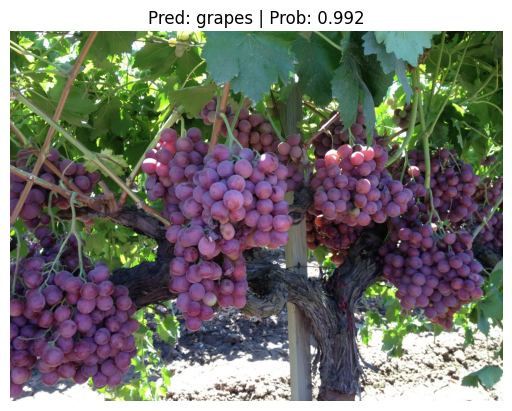

In [23]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "dataset/validation/grapes/Image_7.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)